<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

In [2]:
import numpy as np
import pandas as pd

import re
import multiprocessing
import matplotlib.pyplot as plt
import nltk
from wordcloud import WordCloud
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

from sklearn.metrics import f1_score

from sklearn.utils import shuffle

import time
import os
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

In [3]:
pd.set_option('display.max_columns', None)

In [4]:
path_std = '/datasets/toxic_comments.csv'
path_local = r'C:\Users\ah371\Desktop\резюме\Проекты\NLP\toxic_comments.csv'
if os.path.exists(path_local):
    df = pd.read_csv(path_local, index_col=0)
elif os.path.exist(path_std):
    df = pd.read_csv(path_std, index_col=0)
else:
    print('Ошибка пути')

In [7]:
df.head()

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0


Столбец "Unnamed: 0" явно лишний.

In [8]:
df = df.drop(['Unnamed: 0'], axis=1)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


In [10]:
df.duplicated().sum()

0

In [11]:
df['toxic'].value_counts()

0    143106
1     16186
Name: toxic, dtype: int64

In [12]:
df.sample(5)

,text,toxic
2363,Have you a brit? \n\nThats for you! 80.99.29.195,0
17506,"""\n\nHe clearly says """"I’m Anand...I am Anand ...",0
133490,Hello. Isn't user:Lcnj blocked?,0
96686,I know the going ons between this group of Ind...,0
34002,NPOV and Tone tags \n\nThese were added on 8 M...,0


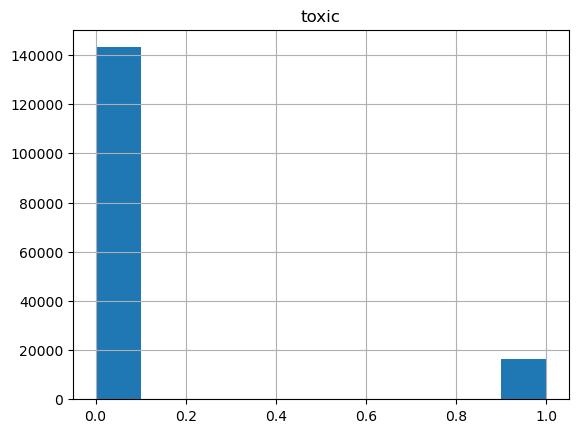

In [13]:
df.hist();

Явный дисбаланс целевого признака.

Данные осмотрены. Удален лишний столбец. Дубликатов нет.\
Заметен дисбаласн классов, который учтем позже.

**Очистим комментарии и лемматизируем их.**

Функция очистки

In [14]:
def clear_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z]', ' ', text)   
    text = ' '.join(text.split())
    return text

РОS-тэгирования слов

In [15]:
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,               #прилагательное
                "N": wordnet.NOUN,              #существительное
                "V": wordnet.VERB,              #глагол
                "R": wordnet.ADV                #наречие
               }  
    return tag_dict.get(tag, wordnet.NOUN)

Лемматизация

In [16]:
lemmatizer = WordNetLemmatizer()
def lemm_text(text):
    text = [lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in nltk.word_tokenize(text)]
    return ' '.join(text)

In [17]:
tqdm.pandas(desc='bar')

In [18]:
df['clean_text'] = df['text'].progress_apply(clear_text) 

bar: 100%|██████████| 159292/159292 [00:02<00:00, 59109.66it/s]


In [19]:
%%time
df['clean_text'] = df['clean_text'].progress_apply(lemm_text)

bar: 100%|██████████| 159292/159292 [42:55<00:00, 61.84it/s] 

Wall time: 42min 55s


In [20]:
df.head()

,text,toxic,clean_text
0,Explanation\nWhy the edits made under my usern...,0,explanation why the edits make under my userna...
1,D'aww! He matches this background colour I'm s...,0,d aww he match this background colour i m seem...
2,"Hey man, I'm really not trying to edit war. It...",0,hey man i m really not try to edit war it s ju...
3,"""\nMore\nI can't make any real suggestions on ...",0,more i can t make any real suggestion on impro...
4,"You, sir, are my hero. Any chance you remember...",0,you sir be my hero any chance you remember wha...


In [21]:
df_toxic = df.drop(['text'], axis=1)

In [22]:
toxic = df_toxic.query('toxic == 1')
good = df_toxic.query('toxic == 0')

In [23]:
good_comments = ' '.join(good['clean_text'])
toxic_comments = ' '.join(toxic['clean_text'])

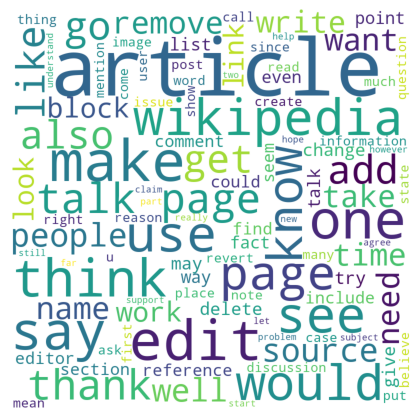

In [24]:
stop_words = set(stopwords.words('english'))

wordcloud = WordCloud(width=800, height=800, background_color='white', 
                      max_words=100, stopwords=stop_words).generate(good_comments)

plt.figure(figsize=(8, 4), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

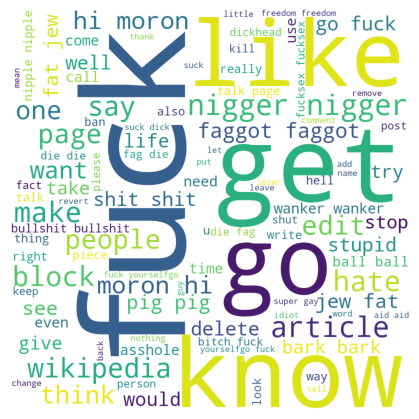

In [25]:
stop_words = set(stopwords.words('english'))

wordcloud = WordCloud(width=800, height=800, background_color='white', 
                      max_words=100, stopwords=stop_words).generate(toxic_comments)

plt.figure(figsize=(8, 4), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

Сделаю выборки.

In [26]:
features = df_toxic.drop(['toxic'], axis=1) 
target = df_toxic['toxic']

features_train, features_test, target_train, target_test = train_test_split(features, 
                                                                              target, 
                                                                              test_size=0.2, 
                                                                              random_state=42,
                                                                              stratify=target)

In [27]:
print(features_train.shape, target_train.shape, 
      features_test.shape, target_test.shape)

(127433, 1) (127433,) (31859, 1) (31859,)


In [28]:
target_train.value_counts()

0    114484
1     12949
Name: toxic, dtype: int64

После деления дисбаланс сохраняется, как и предполагалось.\
Поборемся с дисбалансом.

In [29]:
mask_0 = target_train == 0
mask_1 = target_train == 1

target_train_0_resample = target_train[mask_0].sample(sum(mask_1), random_state=42)

target_train_resample = pd.concat([target_train_0_resample, target_train[mask_1]])

features_train_resample = features_train.loc[target_train_resample.index]

features_train_resample, target_train_resample = shuffle(features_train_resample,
                                                         target_train_resample,
                                                         random_state=42)

print('Баланс классов:')
print(target_train_resample.value_counts(normalize=True))
print(features_train_resample.shape)
print(target_train_resample.shape)

Баланс классов:
1    0.5
0    0.5
Name: toxic, dtype: float64
(25898, 1)
(25898,)


In [30]:
target_train_resample.info()

<class 'pandas.core.series.Series'>
Int64Index: 25898 entries, 136742 to 76605
Series name: toxic
Non-Null Count  Dtype
--------------  -----
25898 non-null  int64
dtypes: int64(1)
memory usage: 404.7 KB


Данные подготовлены. Нужно только перевести в векторы и применить модели.

## Обучение

Что я хочу сказать, ресемплинг я делал зря. Ни одна из трех моделей с балансированной выборкой не дали необходимую метрику даже на валидационной выборке, сколько бы я не мучился с гиперпараметрами.\
Поэтому ниже в моделях, выборки я беру дисбалансные, и указываю в гиперпараметрах на необходимость балансировки.

**Логистическая регрессия**

In [31]:
%%time

pipeline = Pipeline([("vect", TfidfVectorizer(stop_words='english', sublinear_tf=True)), 
                     ("lr", LogisticRegression())])
    
parameters = {'lr__C': [10],
              'lr__solver': ['liblinear', 'lbfgs', 'saga', 'newton-cg'],
              'lr__max_iter': [100, 200],
              'lr__class_weight': ['balanced'],
              'lr__random_state': [42]}

gscv = GridSearchCV(pipeline, parameters, scoring='f1', cv=5, n_jobs=-1)
start = time.time()
gscv.fit(features_train.clean_text, target_train)
end = time.time()

lr = gscv.best_estimator_
lr_time = end - start
lr_train_f1 = round(gscv.best_score_,3)

print('F1 логистической регрессии =', lr_train_f1)
print('при параметрах', gscv.best_params_)
print()

F1 логистической регрессии = 0.765
при параметрах {'lr__C': 10, 'lr__class_weight': 'balanced', 'lr__max_iter': 100, 'lr__random_state': 42, 'lr__solver': 'saga'}

Wall time: 1min 7s


**CatBoost**

In [32]:
%%time

pipeline = Pipeline([("vect", TfidfVectorizer(stop_words='english')), 
                     ("cbc", CatBoostClassifier())])
    
parameters = {'cbc__verbose': ([False]),
              'cbc__iterations': ([300]),
              'cbc__random_state': [42]}

gscv = GridSearchCV(pipeline, parameters, scoring='f1', cv=3, n_jobs=-1)
start = time.time()
gscv.fit(features_train.clean_text, target_train)
end = time.time()


cbc = gscv.best_estimator_
cbc_time = end - start
cbc_train_f1 = round(gscv.best_score_, 3)

print('F1 CatBoostClassifier =', cbc_train_f1)
print('при параметрах', gscv.best_params_)
print()

F1 CatBoostClassifier = 0.74
при параметрах {'cbc__iterations': 300, 'cbc__random_state': 42, 'cbc__verbose': False}

Wall time: 7min 14s


**LGBM**

In [33]:
%%time

pipeline = Pipeline([("vect", TfidfVectorizer(stop_words='english')), 
                     ("lgbm", LGBMClassifier())])
    
parameters = {'lgbm__n_estimators': [500],
              'lgbm__learning_rate': [0.1],
              'lgbm__class_weight': ['balanced'],
              'lgbm__random_state': [42]}

gscv = GridSearchCV(pipeline, parameters, scoring='f1', cv=3, n_jobs=-1)
start = time.time()
gscv.fit(features_train.clean_text, target_train)
end = time.time()

lgbm = gscv.best_estimator_
lgbm_time = end - start
lgbm_train_f1 = round(gscv.best_score_, 3)

print('F1 LGBMClassifier =', lgbm_train_f1)
print('при параметрах', gscv.best_params_)
print()

[LightGBM] [Info] Number of positive: 12949, number of negative: 114484
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.832636 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 519148
[LightGBM] [Info] Number of data points in the train set: 127433, number of used features: 9765
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
F1 LGBMClassifier = 0.758
при параметрах {'lgbm__class_weight': 'balanced', 'lgbm__learning_rate': 0.1, 'lgbm__n_estimators': 500, 'lgbm__random_state': 42}

Wall time: 1min 31s


In [34]:
index = ['LogisticRegression',
         'CatBoostClassifier',
         'LGBMClassifier',
         ]

data = {'F1 на валидации': [lr_train_f1,
                                    cbc_train_f1,
                                    lgbm_train_f1],
        
        'Время обучения': [lr_time,
                          cbc_time,
                          lgbm_time]}
        
f1_data = pd.DataFrame(data=data, index=index)

In [35]:
f1_data

,F1 на валидации,Время обучения
LogisticRegression,0.765,67.772510
CatBoostClassifier,0.740,434.730607
LGBMClassifier,0.758,91.401585


Логистическая регрессия при меньшем времени дает лучший результат. Выбираем её.

In [36]:
def pred(model):
    predictions_test = model.predict(features_test.clean_text)
    return f1_score(target_test, predictions_test)

In [37]:
print(f'F1-мера на тестовой выборке у логистической регрессии: {pred(lr)}')

F1-мера на тестовой выборке у логистической регрессии: 0.7775952693823914


Минимальный порог достигнут.

## Выводы

Были загружены и проанализированы данные. Удален лишний столбец. Создана функция по очистке комментариев и их лемматизации. Подготовленные тексты были разделены. Был произведено ресемплирование с уменьшением класса 0, которое оказалось менее удачным, чем методы встроенные в модели для борьбы с дисбалансом. Были построены три модели: логистическая регрессия, catboost и lgbm. На валидационной выборке лучшей оказалась логистическая регрессия с результатом 0,758. Lgbm получила сравнительный результат, но при больших затратах во времени (почти полминуты). Catboost самый длительный и с худшей метрикой.\
На тестовой выборке логистическая регрессия сохранила свой показатель метрики выше заявленной границы.\
Задачу можно считать выполненной.